MSE: 0.26658405837038673
RMSE: 0.5163177881599537


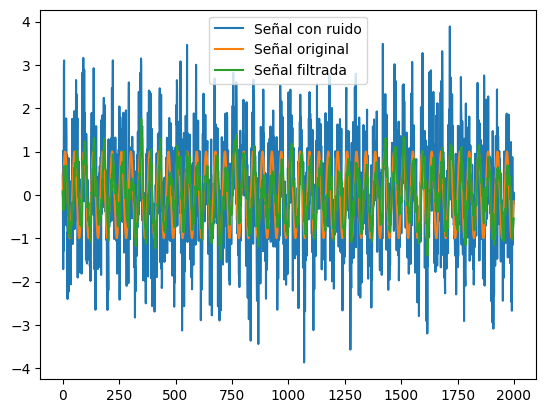

In [1]:
from KalmanFilter import KalmanFilter
from SignalGenerator import SignalGenerator
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar (optional)

# Create a synthetic signal
# Signal parameters
frequency = 480  # Hz
sampling_rate = 20000  # Hz
duration = 0.1  # seconds (100 ms)

SigGen = SignalGenerator(frequency, sampling_rate, duration);

# Generate a clean 400 Hz sine wave
true_signal = SigGen.generate_signal('sine')

# Add noise to create noisy measurement
noise_std = 1
noisy_signal = SigGen.add_noise(true_signal, noise_std)

# Initialize Kalman filter
F = np.array([[1]])
H = np.array([[1]])
Q = np.array([[0.172259]])
R = np.array([[5.872787]])
P = np.array([[1]])
x = np.array([[0]])

# Create and apply filter
kf = KalmanFilter(F, H, Q, R, P, x)
filtered_signal = kf.filter(noisy_signal)

# Calculate error metrics
mse, rmse = kf.calculate_error(true_signal, filtered_signal)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plot results
kf.plot_results(noisy_signal, true_signal, filtered_signal)


In [ ]:
# Grid search to find optimal Q and R values

# Define range of values to test
# q_values = np.logspace(-6, 2, 1000)  # 10 values from 0.000001 to 100  23 horas de procesamiento
# r_values = np.logspace(-6, 2, 1000)  # 10 values from 0.000001 to 100

q_values = np.logspace(-3, 2, 200)  # 10 values from 0.000001 to 100
r_values = np.logspace(-3, 2, 200)  # 10 values from 0.000001 to 100

# Store results
results = []
best_rmse = float('inf')
best_q = None
best_r = None

# Grid search
print("Running grid search for optimal Q and R values...")
for q_val in tqdm(q_values):
    for r_val in r_values:
        # Initialize Kalman filter with current parameters
        Q = np.array([[q_val]])
        R = np.array([[r_val]])

        # Create and apply filter
        kf = KalmanFilter(F, H, Q, R, P, x)
        filtered = kf.filter(noisy_signal)

        # Calculate error
        _, rmse = kf.calculate_error(true_signal, filtered)
        results.append((q_val, r_val, rmse))

        # Track best parameters
        if rmse < best_rmse:
            best_rmse = rmse
            best_q = q_val
            best_r = r_val

# Print best parameters
print(f"Best parameters found: Q={best_q:.6f}, R={best_r:.6f}")
print(f"Best RMSE: {best_rmse:.6f}")

# Create filter with optimal parameters
optimal_Q = np.array([[best_q]])
optimal_R = np.array([[best_r]])
optimal_kf = KalmanFilter(F, H, optimal_Q, optimal_R, P, x)
optimal_filtered = optimal_kf.filter(noisy_signal)

# Calculate improvement over original parameters
original_mse, original_rmse = kf.calculate_error(true_signal, filtered_signal)
optimal_mse, optimal_rmse = kf.calculate_error(true_signal, optimal_filtered)
improvement = ((original_rmse - optimal_rmse) / original_rmse) * 100

print(f"Original RMSE: {original_rmse:.6f}")
print(f"Optimal RMSE: {optimal_rmse:.6f}")
print(f"Improvement: {improvement:.2f}%")

# Plot results with optimal parameters
plt.figure(figsize=(12, 6))
plt.plot(noisy_signal, label='Noisy signal')
plt.plot(true_signal, label='True signal')
plt.plot(optimal_filtered, label='Optimized filter')
plt.legend()
plt.title(f'Kalman Filter with Optimal Parameters (Q={best_q:.6f}, R={best_r:.6f})')
plt.show()

# Create heatmap of RMSE values
rmse_grid = np.zeros((len(q_values), len(r_values)))
for i, q in enumerate(q_values):
    for j, r in enumerate(r_values):
        for result in results:
            if result[0] == q and result[1] == r:
                rmse_grid[i, j] = result[2]
                break

plt.figure(figsize=(10, 8))
plt.imshow(rmse_grid, cmap='viridis', aspect='auto', origin='lower',
           extent=[np.log10(r_values[0]), np.log10(r_values[-1]),
                   np.log10(q_values[0]), np.log10(q_values[-1])])
plt.colorbar(label='RMSE')
plt.xlabel('log10(R)')
plt.ylabel('log10(Q)')
plt.title('RMSE for different Q and R values')
plt.show()

Running grid search for optimal Q and R values...


 20%|██        | 40/200 [06:38<26:45, 10.03s/it]

MSE: 0.3963251352268626
RMSE: 0.6295435927931143


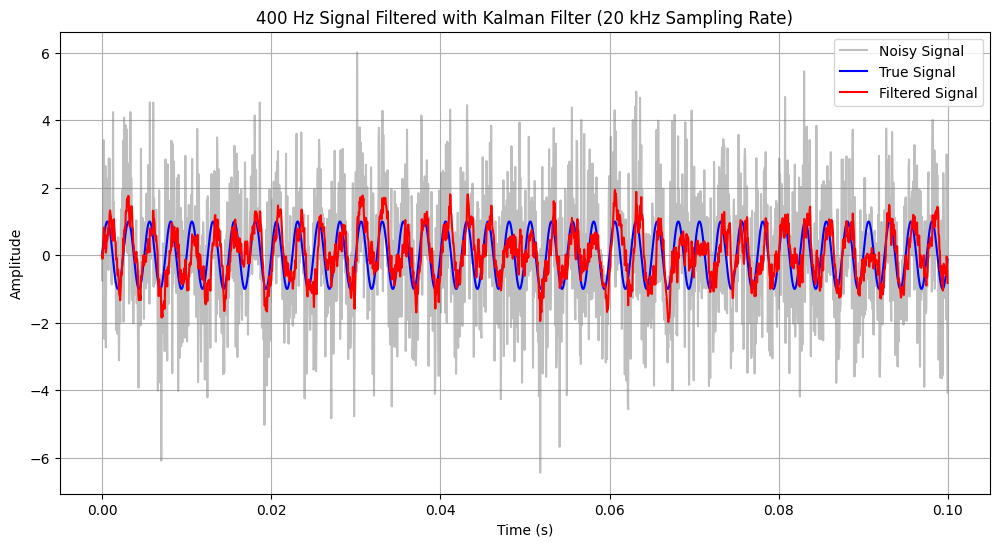

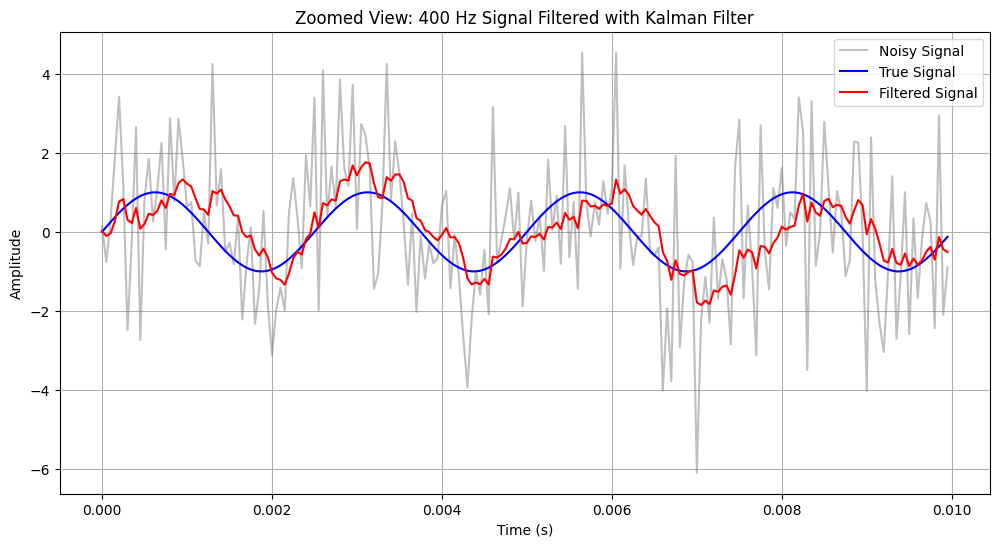

In [3]:
# Test Filter on other signals

# Add noise to create noisy measurement
noise_std = 2
noisy_signal = SigGen.add_noise(true_signal, noise_std)

# Initialize Kalman filter
F = np.array([[1]])
H = np.array([[1]])
Q = np.array([[best_q]])  # Try different values
R = np.array([[best_r]])  # Approximately noise_std^2
P = np.array([[1]])
x = np.array([[0]])

# Create and apply filter
kf = KalmanFilter(F, H, Q, R, P, x)
filtered_signal = kf.filter(noisy_signal)

# Calculate error metrics
mse, rmse = kf.calculate_error(true_signal, filtered_signal)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(t, noisy_signal, 'gray', alpha=0.5, label='Noisy Signal')
plt.plot(t, true_signal, 'b', label='True Signal')
plt.plot(t, filtered_signal, 'r', label='Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('400 Hz Signal Filtered with Kalman Filter (20 kHz Sampling Rate)')
plt.legend()
plt.grid(True)

# Zoom in to show detail
plt.figure(figsize=(12, 6))
zoom_samples = int(0.01 * sampling_rate)  # Show 10ms
plt.plot(t[:zoom_samples], noisy_signal[:zoom_samples], 'gray', alpha=0.5, label='Noisy Signal')
plt.plot(t[:zoom_samples], true_signal[:zoom_samples], 'b', label='True Signal')
plt.plot(t[:zoom_samples], filtered_signal[:zoom_samples], 'r', label='Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Zoomed View: 400 Hz Signal Filtered with Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()